<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

## Finding edge cases for automated retraining on a Binary Classification Task [Tensorflow]

In this example, we consider a binary classification task of human pose estimation. That is, given the location of key-points such as face, shoulders, wrist, hips, ankles, etc., of a person, the model tries to predict whether the person is in a horizontal (see image 1 below) or a vertical (see image 2 below) position.

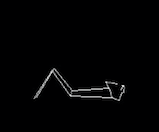
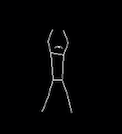

After training our model, we will use the UpTrain Framework to identify edge cases during testing and retrain the binary classification model to improve its accuracy.

### Install the required packages for this example

In [ ]:
!pip install imgaug

Note: Also requires tensorflow to be installed. We ran the following code successfully with tensorflow version 2.11.0.

In [1]:
import os
import subprocess
import zipfile
import numpy as np
from contextlib import redirect_stdout
import uptrain

import sys
sys.path.append('..')

from helper_files import read_json, write_json, KpsDataset
from helper_files import pushup_signal

First, let's download the preprocessed training and testing datasets

In [2]:
data_dir = "data"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/data.zip"
orig_training_file = 'data/training_data.json'
if not os.path.exists(data_dir):
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
        with zipfile.ZipFile("data.zip", 'r') as zip_ref:
            zip_ref.extractall("./")
        full_training_data = read_json(orig_training_file)
        np.random.seed(1)
        np.random.shuffle(full_training_data)
        reduced_training_data = full_training_data[0:1000]
        write_json(orig_training_file, reduced_training_data)
        print("Prepared Example Dataset")
        os.remove("data.zip")
    except Exception as e:
        print(e)
        print("Could not load training data")

### Training using Deep Neural Network (with Tensorflow)

In [3]:
import tensorflow as tf
from helper_files.model_tensorflow import get_accuracy_tf, train_model_tf
tf.config.set_visible_devices([], 'GPU')

# Training file contains the dataset to train the model on
training_file = 'data/training_data.json'
train_model_tf(training_file, 'version_0')

Training on:  data/training_data.json  which has  1000  data-points


2023-01-21 13:29:16.279526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
62/62 [==============================] - 0s 558us/step - loss: 42.5705 - binary_accuracy: 0.4355
Epoch 2/10
62/62 [==============================] - 0s 538us/step - loss: 14.5901 - binary_accuracy: 0.5141
Epoch 3/10
62/62 [==============================] - 0s 544us/step - loss: 7.2051 - binary_accuracy: 0.6351
Epoch 4/10
62/62 [==============================] - 0s 539us/step - loss: 3.6405 - binary_accuracy: 0.7853
Epoch 5/10
62/62 [==============================] - 0s 540us/step - loss: 2.4533 - binary_accuracy: 0.8619
Epoch 6/10
62/62 [==============================] - 0s 533us/step - loss: 1.9468 - binary_accuracy: 0.8831
Epoch 7/10
62/62 [==============================] - 0s 546us/step - loss: 1.6374 - binary_accuracy: 0.9032
Epoch 8/10
62/62 [==============================] - 0s 545us/step - loss: 1.4705 - binary_accuracy: 0.9153
Epoch 9/10
62/62 [==============================] - 0s 542us/step - loss: 1.3387 - binary_accuracy: 0.9224
Epoch 10/10
62/62 [================

Next, we evaluate the model on our golden testing dataset to see it's accuracy.

In [4]:
# Golden testing file contains a testing dataset to evaluate model performance
golden_testing_file = 'data/golden_testing_data.json'
get_accuracy_tf(golden_testing_file, 'version_0')

Evaluating on  15731  data-points
492/492 [==============================] - 0s 353us/step


0.9386561566333991

We note that the testing accuracy of the model is low for such as simple task. 
On digging down further, we observed that model's outputs were unreliable in cases where the person was in a pushup position. Next, we will define the UpTrain config with edge-case check for Pushup signals. We also pass our training and evaluation arguments to facilitate automated retraining if a significant number of edge cases are detected.

In [5]:
# Real world test cases contains the data-points which the models sees in production
real_world_test_cases = 'data/real_world_testing_data.json'

# To annotate the collected data points, we extract the ground truth from the master annotation file 
# (this can also do something like schedule an annotation job on Mechanical turk or 
# integrate with your other annotation pipelines).
annotation_args = {'master_file': 'data/master_annotation_data.json'}

# Log the collected data-points to a local folder (this can also be a SQL table, a data warehouse etc.).
data_save_folder = 'uptrain_smart_data_edge_cases_tf'

# Defining the pushup egde-case signal
pushup_edge_case = uptrain.Signal("Pushup", pushup_signal)

# Defining the model confidence edge-case signal
# That is, identify model confidence <0.9 as an edge-case
low_conf_edge_case = uptrain.Signal(uptrain.ModelSignal.BINARY_ENTROPY_CONFIDENCE, 
                is_model_signal=True) < 0.9

cfg = {
    # Define your signal to identify edge cases
    "checks": [{
        'type': uptrain.Monitor.EDGE_CASE, 
        "signal_formulae": (pushup_edge_case | low_conf_edge_case)
    }],

    # Connect training pipeline to annotate data and retrain the model
    "training_args": { 
        "annotation_method": {"method": uptrain.AnnotationMethod.MASTER_FILE, "args": annotation_args}, 
        "training_func": train_model_tf, 
        "orig_training_file": orig_training_file,  
    },

    # Retrain once 250 edge cases are collected
    "retrain_after": 250,
    
    # A local folder to store the retraining dataset
    "retraining_folder": "uptrain_smart_data_edge_cases_tf",

    # Connect evaluation pipeline to test retrained model against original model
    "evaluation_args": {
        "inference_func": get_accuracy_tf,
        "golden_testing_dataset": golden_testing_file,
    },
}

To integrate UpTrain, we need to just initialise a Framework object with above-defined config and log model inputs and outputs in our inference function. 

In [6]:
framework = uptrain.Framework(cfg)

To mimic real-world settings, we take a real-world testing dataset, load data-points batch by batch and run the model inference on them.

In [7]:
model_dir = 'trained_models_tf/'
model_save_name = 'version_0'
inference_batch_size = 16
real_world_dataset = KpsDataset(
    real_world_test_cases, batch_size=inference_batch_size, shuffle=False, augmentations=False, is_test=True
)
model = tf.keras.models.load_model(model_dir + model_save_name)
gt_data = read_json(annotation_args['master_file'])
all_gt_ids = [x['id'] for x in gt_data]

for i,elem in enumerate(real_world_dataset):

    # Do model prediction
    inputs = {"kps": elem[0]["kps"], "id": elem[0]["id"]}
    preds = model.predict(inputs['kps'])

    # Log model inputs and outputs to the uptrain Framework
    idens = framework.log(inputs=inputs, outputs=preds)

    # Retrain only once
    if framework.version > 1:
        break

1/1 [==============================] - 0s 10ms/step
50  data-points collected out of  688  inferred samples
1/1 [==============================] - 0s 10ms/step
100  data-points collected out of  1328  inferred samples
1/1 [==============================] - 0s 10ms/step
152  data-points collected out of  1920  inferred samples
1/1 [==============================] - 0s 11ms/step
200  data-points collected out of  2592  inferred samples
1/1 [==============================] - 0s 11ms/step
250  data-points collected out of  3200  inferred samples
1/1 [==============================] - 0s 11ms/step
Kicking off re-training
251 data-points selected out of 3216
Training on:  uptrain_smart_data_edge_cases_tf/1/training_dataset.json  which has  2255  data-points
Epoch 1/10
140/140 [==============================] - 0s 572us/step - loss: 46.8356 - binary_accuracy: 0.5518
Epoch 2/10
140/140 [==============================] - 0s 525us/step - loss: 3.1095 - binary_accuracy: 0.8214
Epoch 3/10
140/140 

#### Hooray! The accuracy after retraining with edge cases has improved

In the comparison report above, we can see how UpTrain improved the model performance by detecting edge-cases and retraining the model under-the-hood. Following are some of the edge-case images caught by the UpTrain framework.

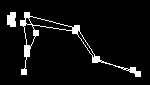
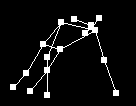
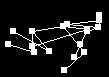